In [180]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import math

import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

In [2]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/16thRun/"

In [3]:
Ups4S_file = uproot.open(nfs_path + "Ups4S_NN_predicted.root:variables;1")
df_Ups4S = Ups4S_file.arrays(library="pd")

In [57]:
FSPs_file = uproot.open(nfs_path + "FSPs.root:variables;1")
df_FSPs = FSPs_file.arrays(library="pd")

In [15]:
#evt_counter_file = uproot.open(nfs_path + "evt_counter.root:variables;1")
#df_evt_counter = evt_counter_file.arrays(library="pd")

KeyboardInterrupt: 

In [5]:
print(df_Ups4S.shape[0])
print(df_Ups4S.groupby(["__event__","__production__"]).ngroups)
print(df_Ups4S["__event__"].nunique())

3499182
189018
189017


## choose BCS and add labels

In [7]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')
print(BCS_df.shape[0])

189017


In [8]:
imputelist = [["abs_genUp4S_PDG_0_0",0],["abs_genUp4S_PDG_0_1",0],["abs_genUp4S_PDG_0_2",0],
              ["abs_genUp4S_PDG_1_0",0],["abs_genUp4S_PDG_1_1",0],["abs_genUp4S_PDG_1_2",0]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]

    print(BCS_df[BCS_df[column_name].isna() == True].shape[0])
    mask = BCS_df[column_name].isna() == 1
    BCS_df.loc[mask, column_name] = impute_val
    print(BCS_df[BCS_df[column_name].isna() == True].shape[0])

0
0
0
0
29449
0
0
0
0
0
29190
0


In [9]:
def isDstlnu(s):
    isDstlnu = 0

    abs_genUp4S_PDG_0_0 = int(s["abs_genUp4S_PDG_0_0"])
    abs_genUp4S_PDG_0_1 = int(s["abs_genUp4S_PDG_0_1"])
    abs_genUp4S_PDG_0_2 = int(s["abs_genUp4S_PDG_0_2"])
                              
    abs_genUp4S_PDG_1_0 = int(s["abs_genUp4S_PDG_1_0"])
    abs_genUp4S_PDG_1_1 = int(s["abs_genUp4S_PDG_1_1"])
    abs_genUp4S_PDG_1_2 = int(s["abs_genUp4S_PDG_1_2"])
    
    if abs_genUp4S_PDG_0_0 == 413:
        if abs_genUp4S_PDG_0_1 == 11 or abs_genUp4S_PDG_0_1 == 13:
            if abs_genUp4S_PDG_0_2 == 12 or abs_genUp4S_PDG_0_2 == 14:              
                isDstlnu = 1
                                  
    if abs_genUp4S_PDG_1_0 == 413:
        if abs_genUp4S_PDG_1_1 == 11 or abs_genUp4S_PDG_1_1 == 13:
            if abs_genUp4S_PDG_1_2 == 12 or abs_genUp4S_PDG_1_2 == 14:              
                isDstlnu = 1        
        
    return isDstlnu

BCS_df['isDstlnu'] = BCS_df.apply(isDstlnu, axis=1)

In [10]:
def lep_typeMC(s):
    label = "none"
    if np.isnan(s["lep_mcPDG"]) == True:
        return label
    
    abs_lep_mcPDG = int(abs(s["lep_mcPDG"]))
    if abs_lep_mcPDG == 13:
        label = "mu"
    elif abs_lep_mcPDG == 11:
        label = "e" 
    return label

BCS_df['lep_typeMC'] = BCS_df.apply(lep_typeMC, axis=1)

def lep_type(s):
    label = "none"
    if np.isnan(s["lep_PDG"]) == True:
        return label
    
    abs_lep_PDG = int(abs(s["lep_PDG"]))
    if abs_lep_PDG == 13:
        label = "mu"
    elif abs_lep_PDG == 11:
        label = "e" 
    return label
BCS_df['lep_type'] = BCS_df.apply(lep_type, axis=1)

In [11]:
def lep_MC_truth(s):
    label = 0
    if np.isnan(s["lep_motherPDG"]) == True:
        return label
    if s["lep_typeMC"] == "none":
        return label
    
    abs_lep_motherPDG = int(abs(s["lep_motherPDG"]))
    if abs_lep_motherPDG == 511:
        label = 1
   
    return label

BCS_df['lep_MC_truth'] = BCS_df.apply(lep_MC_truth, axis=1)

In [17]:
BCS_df['isDstlnu'].mean()

0.19702989678177096

In [18]:
BCS_df['lep_MC_truth'].mean()

0.23783045969410158

In [19]:
BCS_df['custom_signal'] = (BCS_df['lep_MC_truth'] & BCS_df['isDstlnu'])

In [6]:
BCS_df['custom_signal'].mean()

0.1423734373098716

<AxesSubplot:>

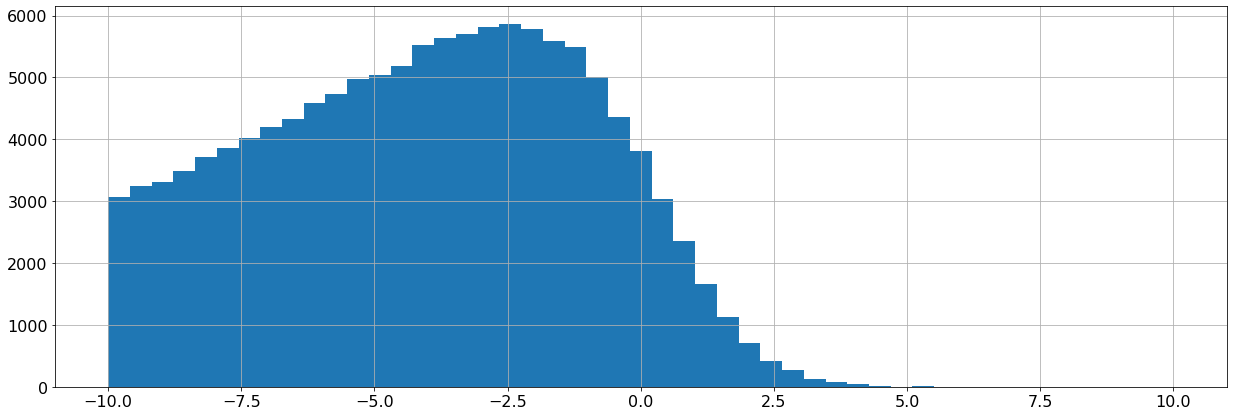

In [61]:
bins = np.linspace(-10, 10, 50)
BCS_df["dau1_cosThetaBetweenParticleAndNominalB"].hist(bins=bins)

## add info about leps in Btag to data frame

In [107]:
df_FSPs["lep"] = ((df_FSPs["PDG"] == 11.) | (df_FSPs["PDG"] == 13.))

In [108]:
df_FSPs["Btag"] = ((df_FSPs["basf2_used"] == 1.) & (df_FSPs["basf2_Bsig"] == 0.))

In [109]:
df_FSPs["Btag_lep"] = ((df_FSPs["Btag"] == 1.) & (df_FSPs["lep"] == 1.))

In [110]:
df_FSPs["Btag_lep"].mean()

0.021691284098784135

In [111]:
N_Btag_lep = pd.DataFrame({'N_lep_Btag' : df_FSPs.groupby( ["__event__","Btag_lep"] ).size()}).reset_index()

N_Btag_lep[N_Btag_lep["Btag_lep"] == True]["N_lep_Btag"].sum()

91804

In [112]:
column_name = "N_lep_Btag"
impute_val = 0

mask = N_Btag_lep["Btag_lep"] == False
N_Btag_lep.loc[mask, column_name] = impute_val

N_Btag_lep["N_lep_Btag"].sum()

91804

In [113]:
N_Btag_lep = N_Btag_lep.sort_values("N_lep_Btag",ascending=False).drop_duplicates(subset=("__event__"), keep='first')
N_Btag_lep["N_lep_Btag"].sum()

91804

In [114]:
BCS_df = BCS_df.merge(N_Btag_lep[["__event__","N_lep_Btag"]], how='inner', on="__event__")

In [115]:
BCS_df["N_lep_Btag"].sum()

91804

## save df with labels

In [116]:
BCS_df.to_csv(nfs_path + "BCS_df_wLabels.csv")

## load df with labels

In [106]:
BCS_df = pd.read_csv(nfs_path + "BCS_df_wLabels.csv")

<AxesSubplot:>

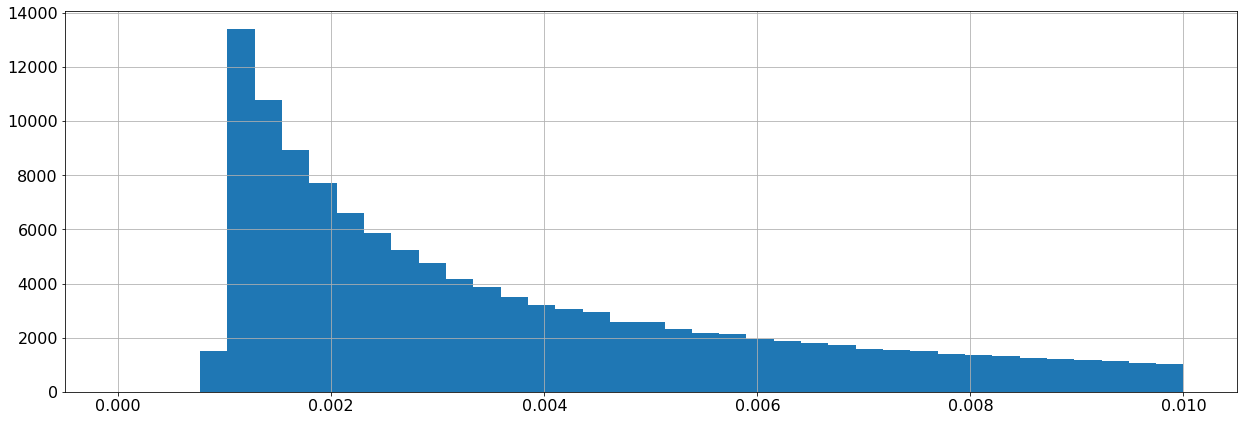

In [207]:
bins=np.linspace(0, 0.01, 40)
BCS_df["dau0_dau0_sigProb"].hist(bins=bins)

## calculate eff. and purity for all cuts separately

In [4]:
#N_evts_processed = df_evt_counter.shape[0]
N_evts_processed = 189000 * 539 # 189000 evts for each of the 539 files processed
N_evts_expected = N_evts_processed * 0.3 * 0.05  # expected D*lnu (BR:5%) with specific D0 modes (BR:30%) events

N_evts_expected

1528065.0

In [123]:
def append_lists(df, effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec):
    num_evts = df.shape[0]
    efficiency = num_evts / N_evts_expected
    N_selec.append(num_evts)
    effs.append(efficiency)

    purity_Dstlnu = df[df["isDstlnu"] == 1].shape[0] / num_evts
    purities_Dstlnu.append(purity_Dstlnu)
    N_pure.append(df[df["isDstlnu"] == 1].shape[0])
    purity_DstAndLep = df[df["custom_signal"] == 1].shape[0] / num_evts
    purities_DstAndLep.append(purity_DstAndLep)
    
    return effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec

In [234]:
cut_names = []
effs=[]
N_pure=[]
N_selec=[]
purities_Dstlnu=[]
purities_DstAndLep=[]
#######################################
cut_names.append("no cuts")

effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(BCS_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag Mbc")
dau0_Mbc_lower = 5.00

cut_df = BCS_df[BCS_df.dau0_Mbc > dau0_Mbc_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag deltaE")
dau0_deltaE_lim = 0.5

cut_df = BCS_df[(BCS_df.dau0_deltaE < dau0_deltaE_lim) & (BCS_df.dau0_deltaE > -dau0_deltaE_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("foxWolframR2")
foxWolframR2_lim = 0.3

cut_df = BCS_df[(BCS_df.foxWolframR2 < foxWolframR2_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst_pt")
Dst_pt_upper = 2.4

cut_df = BCS_df[(BCS_df.Dst_pt < Dst_pt_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("lep_pt")
lep_pt_lower = 0.7

cut_df = BCS_df[(BCS_df.lep_pt > lep_pt_lower)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("D0 mass")
D_M_upper = 1.95
D_M_lower = 1.8

cut_df = BCS_df[(BCS_df.D_M > D_M_lower) & (BCS_df.D_M < D_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst mass")
Dst_M_lower = 1.8
Dst_M_upper = 2.2

cut_df = BCS_df[(BCS_df.Dst_M > Dst_M_lower) & (BCS_df.Dst_M < Dst_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("hadr. Btag")
cut_df = BCS_df[(BCS_df.N_lep_Btag == 0)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("HcSigProb>0.01")
dau0_dau0_sigProb_lower = 0.01

cut_df = BCS_df[BCS_df.dau0_dau0_sigProb > dau0_dau0_sigProb_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("SigProb>0.1")
dau0_dau0_sigProb_lower = 0.1

cut_df = BCS_df[BCS_df.dau0_dau0_sigProb > dau0_dau0_sigProb_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################

In [235]:
eff_and_pur = pd.DataFrame({'cut_name' : cut_names,
                            'N tagged evts' : N_selec,
                            'N tagged signal evts' : N_pure,
                           'efficiency' : effs,
                           'purity_Dst' : purities_Dstlnu,
                           'purity_DstAndLep' : purities_DstAndLep})

In [236]:
eff_and_pur

,cut_name,N tagged evts,N tagged signal evts,efficiency,purity_Dst,purity_DstAndLep
0,no cuts,189017,37242,0.123697,0.197030,0.142373
1,Btag Mbc,146170,30137,0.095657,0.206178,0.160183
2,Btag deltaE,54944,5405,0.035957,0.098373,0.067560
3,foxWolframR2,182264,34741,0.119278,0.190608,0.137932
4,Dst_pt,188659,37204,0.123463,0.197202,0.142548
5,lep_pt,65957,25934,0.043164,0.393196,0.367179
6,D0 mass,3634,562,0.002378,0.154651,0.096037
7,Dst mass,18678,3153,0.012223,0.168808,0.110183
8,hadr. Btag,115581,24560,0.075639,0.212492,0.155017
9,HcSigProb>0.01,68870,13826,0.045070,0.200755,0.150414


In [237]:
eff_and_pur.shape[0]

11

In [238]:
eff_and_pur.cut_name

0            no cuts
1           Btag Mbc
2        Btag deltaE
3       foxWolframR2
4             Dst_pt
5             lep_pt
6            D0 mass
7           Dst mass
8         hadr. Btag
9     HcSigProb>0.01
10       SigProb>0.1
Name: cut_name, dtype: object

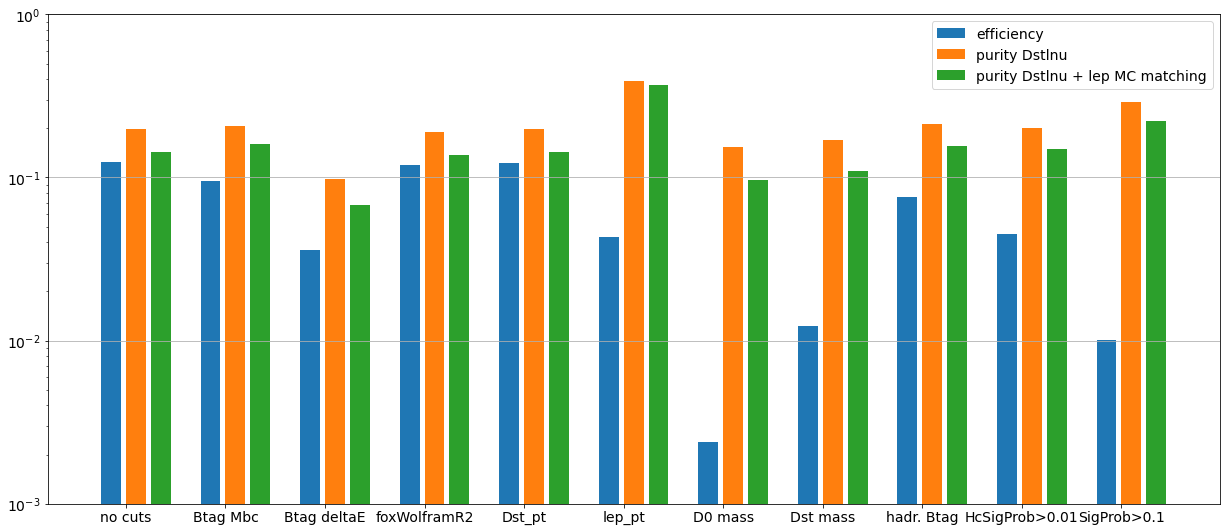

<Figure size 1512x648 with 0 Axes>

In [239]:
plt.rcParams["figure.figsize"] = (21,9)
plt.rcParams.update({'font.size': 14})

ind = np.arange(eff_and_pur.shape[0])
width = 0.2 
shift = 0.25

plt.bar(ind -shift, eff_and_pur['efficiency'], width, label='efficiency')
plt.bar(ind +0.0, eff_and_pur['purity_Dst'], width, label='purity Dstlnu')
plt.bar(ind +shift, eff_and_pur['purity_DstAndLep'], width, label='purity Dstlnu + lep MC matching')
plt.xticks((ind + width / 2)-width, eff_and_pur.cut_name) 
plt.yscale('log')
plt.ylim(ymax = 1, ymin = 0.001)
plt.legend()
plt.grid(axis='y')
plt.show()

plt.savefig('plots/efficiency_and_purity_singleCuts.pdf')

## all cuts adding up

In [160]:
cut_names = []
effs=[]
N_pure=[]
N_selec=[]
purities_Dstlnu=[]
purities_DstAndLep=[]
#######################################
cut_names.append("no cuts")
cut_df = BCS_df

effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag Mbc")

cut_df = cut_df[cut_df.dau0_Mbc > dau0_Mbc_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag deltaE")

cut_df = cut_df[(cut_df.dau0_deltaE < dau0_deltaE_lim) & (cut_df.dau0_deltaE > -dau0_deltaE_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("foxWolframR2")

cut_df = cut_df[(cut_df.foxWolframR2 < foxWolframR2_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst_pt")

cut_df = cut_df[(cut_df.Dst_pt < Dst_pt_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("lep_pt")

cut_df = cut_df[(cut_df.lep_pt > lep_pt_lower)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("D0 mass")

cut_df = cut_df[(cut_df.D_M > D_M_lower) & (cut_df.D_M < D_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst mass")

cut_df = cut_df[(cut_df.Dst_M > Dst_M_lower) & (cut_df.Dst_M < Dst_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("fully hadr. Btag")
cut_df = cut_df[(cut_df.N_lep_Btag == 0)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################

In [161]:
eff_and_pur_addingUp = pd.DataFrame({'cut_name' : cut_names,
                            'N tagged evts' : N_selec,
                            'N tagged signal evts' : N_pure,
                           'efficiency' : effs,
                           'purity_Dst' : purities_Dstlnu,
                           'purity_DstAndLep' : purities_DstAndLep})
eff_and_pur_addingUp

,cut_name,N tagged evts,N tagged signal evts,efficiency,purity_Dst,purity_DstAndLep
0,no cuts,189017,37242,0.123697,0.197030,0.142373
1,Btag Mbc,146170,30137,0.095657,0.206178,0.160183
2,Btag deltaE,40882,4168,0.026754,0.101952,0.078421
3,foxWolframR2,39776,3851,0.026030,0.096817,0.074593
4,Dst_pt,39728,3846,0.025999,0.096808,0.074607
5,lep_pt,11185,2838,0.007320,0.253733,0.241574
6,D0 mass,200,37,0.000131,0.185000,0.185000
7,Dst mass,114,29,0.000075,0.254386,0.254386
8,fully hadr. Btag,60,17,0.000039,0.283333,0.283333


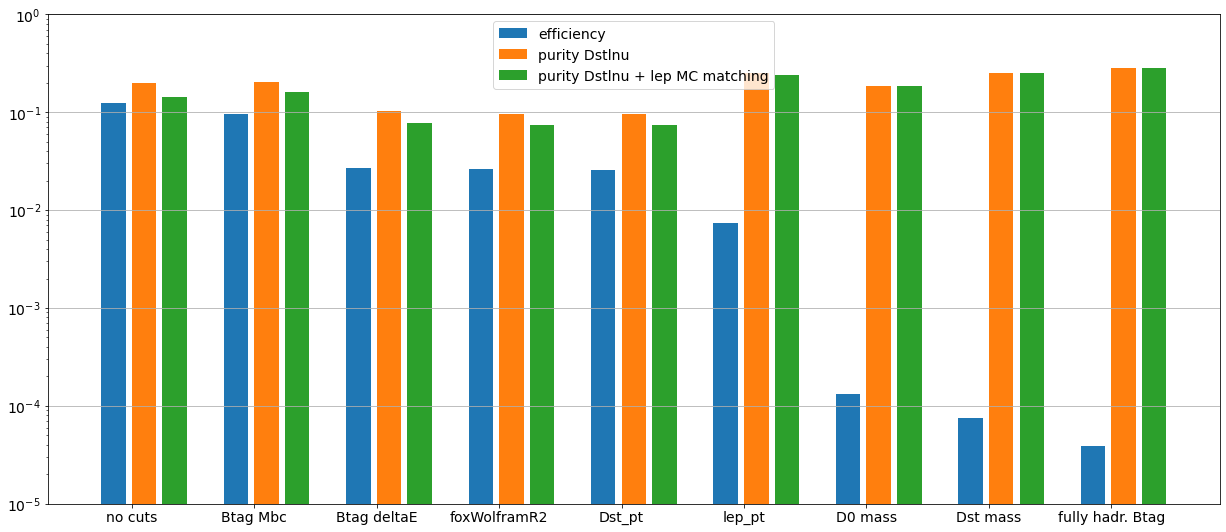

<Figure size 1512x648 with 0 Axes>

In [176]:
plt.rcParams["figure.figsize"] = (21,9)
plt.rcParams.update({'font.size': 14})

ind = np.arange(eff_and_pur.shape[0])
width = 0.2 
shift = 0.25

plt.bar(ind -shift, eff_and_pur_addingUp['efficiency'], width, label='efficiency')
plt.bar(ind +0.0, eff_and_pur_addingUp['purity_Dst'], width, label='purity Dstlnu')
plt.bar(ind +shift, eff_and_pur_addingUp['purity_DstAndLep'], width, label='purity Dstlnu + lep MC matching')
plt.xticks((ind + width / 2)-width, eff_and_pur.cut_name) 
plt.yscale('log')
plt.ylim(ymax = 1, ymin = 0.00001)
plt.grid(axis='y')

plt.legend()

plt.show()


plt.savefig('plots/efficiency_and_purity_stackedCuts.pdf')

In [178]:
plot_vars=["dau0_Mbc","dau0_deltaE","foxWolframR2","Dst_pt","lep_pt","D_M","Dst_M","N_lep_Btag"]

In [196]:
bins_dict = {
    "dau0_Mbc":  np.linspace(4, 5.5, 40),
    "dau0_deltaE":   np.linspace(-5, 5, 40),
    "foxWolframR2":   np.linspace(0, 0.5, 40),
    "Dst_pt":   np.linspace(0, 3, 40),
    "lep_pt":   np.linspace(0, 3, 40),
    "D_M":   np.linspace(0, 4, 40),
    "Dst_M":   np.linspace(0, 4, 40),
    "N_lep_Btag":   np.linspace(0, 5, 6)
    }

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0 0 dau0_Mbc
1 0 dau0_deltaE
2 0 foxWolframR2
3 0 Dst_pt
0 1 lep_pt
1 1 D_M
2 1 Dst_M
3 1 N_lep_Btag


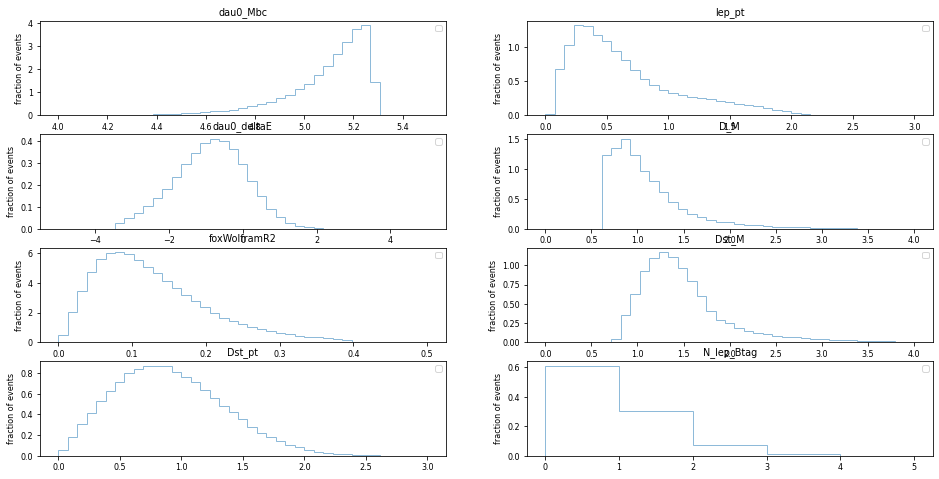

In [197]:
dim_x = 4
fig, axs = plt.subplots(dim_x, 2)
fig.set_size_inches(16, 8)
font_size=8
plt.rcParams.update({'font.size': font_size})


for i, var in enumerate(plot_vars):
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    print(idx, idy, var)
    
    ax = axs[idx, idy]   
    
    bins = bins_dict[var]
    ax.set_title(f'{var}')

    #ax.set_xlabel(r'number of wrong predictions per event')
    ax.set_ylabel("fraction of events",fontsize=font_size)

    #plt.xticks(np.arange(0, num_steps, step=1))
    ax.hist(BCS_df[var], 
            bins, 
            density=True, alpha=0.5, label="" ,histtype='step')
    
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='both', which='minor', labelsize=font_size)

    ax.legend(loc='upper right')

    #plt.grid()

plt.savefig('plots/efficiency_and_purity_variablesDistris.pdf')